# Huristic M-TSP 

The objective is to minimize the length of the
longest path. In practical applications, these objectives correspond
to minimizing total distance traveled by the team and minimizing
mission time, respectively.

### If we calculate correctly the driving time between pairs of jobs, this algorithm may be the best solution.
### We recommend trying it out.

In [1]:
import sys
import numpy as np # used for scientific computing\n",
import pandas as pd # used for data analysis and manipulation\n",
import matplotlib.pyplot as plt # used for visualization and plotting\n",
import matplotlib.cm as cm
import math
from sklearn.preprocessing import MinMaxScaler

In [2]:
# we need to get these 2 as an input
name_of_file = 'first_dataset'
number_of_resources = 21

In [3]:
# read the data 
df = pd.read_excel(f'../Data/with_duration_time/{name_of_file}.xlsx')

In [4]:
class Vertex:
    """
    Vertex on the graph G is a job with:
    id: index in the given excel (in order to update it well),
    location - latitude, longitude,
    expect duration time in minutes.
    """

    def __init__(self, id, lat, lon, duration_time): 
        self.id = id
        self.lat = lat
        self.lon = lon
        self.index = -1
        self.weight = duration_time
    
    def __eq__(self, other):
        return self.id == other.id
    
    def __str__(self):
        return f'({self.lat}, {self.lon}, {self.weight})'

# Note 

* we do not calculate the driving distance. 
* we assume that the speed in any location is the same. Which is probably wrong.

Results may improve by changing the functions compute_distance, proxy_time_between_u_v to functions that estimate time according to the driving way


##### It is enough to change these calculation only in the Edge class  

In [5]:
class Edge:
    """
    Edge is connect between two vetices.(Jobs)
    The weight include also the duration time.
    """
    
    def __init__(self, u, v):
        self.u = u
        self.v = v
        # Each vertex is incident to exactly two edges of the cycle, so we can define the weight of an edge as:
        self.weight = 0.5 * (u.weight + v. weight) + self.proxy_time_between_u_v()
    
        
    def proxy_time_between_u_v(self, alpha=15):
        """
        return the time (under assumption) to go from u to v
        By changing the proxy time to the real driving time the algorithm may improve a lot.
        """
        d = self.compute_distance()
        
        return d * alpha 
    
    
    def compute_distance(self):
        """
        compute the distance (km) between two lat-long coordinates

        """    
        # radius of the Earth
        R = 6373.0

        distance_lat = self.u.lat - self.v.lat
        distance_long = self.u.lon - self.v.lon

        #Haverinse formula 
        x = math.sin(distance_lat / 2)**2 + math.cos(self.v.lat) * math.cos(self.u.lat) * math.sin(distance_long / 2)**2

        y = 2 * math.atan2(math.sqrt(x), math.sqrt(1 - x))

        return (R * y) # / 1000
    
    
    def consist_vertex(self, v):
        return True if self.u == v or self.v == v else False
    
    
    def __str__(self):
        return f'[{self.u}, {self.v}] , w(e) = {self.weight}'

In [6]:
class Graph_i:
    """
    Create a subgraph G_i
    """
    def __init__(self, all_vertices, V_i, E_i):
        self.V = V_i 
        self.length = len(V_i)
        self.E = E_i
        self.weight = sum(edge.weight for edge in E_i) 
        margin_weight_dict = {v.id: (v, self.init_margin_weight(v)) for v in all_vertices}
        # sorted dictionary
        self.margin_weight_dict = dict(sorted(margin_weight_dict.items(), key=lambda item: item[1][1], reverse=True))
        self.size = (2 / (self.length - 1))  * (self.weight)  
    
    
    def init_margin_weight(self, v):
        """
        margin_weight(v) = sum of w(v', v) for v' in V_i
        """
        return sum([Edge(u, v).weight for u in self.V])
    
    
    def get_size_after_transfer_remove(self, v):
        """
        return the size if the remove operation will be executed
        """
        if self.length == 0:
            return sys.float_info.max 

        if self.length == 1:
            return 0
        
        if self.length == 2:
            return self.V[0].weight if self.V[0] == v else self.V[1].weight
        
        return (2 / (self.length - 2)) * (self.weight - self.margin_weight_dict.get(v.id)[1]) 
        
    
    def get_size_after_transfer_add(self, v):
        """
        return the size if the add operation will be executed
        """
        if self.length == 0:
            return v.weight
        
        return (2 / self.length) * (self.weight + self.margin_weight_dict.get(v.id)[1])
    
    
    def get_size_after_swap(self, v, u):
        """
        return the size if the swap operation will be executed such that v in V_i and u is from another sub-graph
        """
        return self.weight - self.margin_weight_dict.get(v.id)[1] + self.margin_weight_dict.get(u.id)[1] - Edge(u, v).weight
    
        
          
    def add_vertex(self, v):
        """
        Add vertex to the graph_i.
        Update the the fields as needed.
        """
        self.V += [v]
        self.length += 1
        self.weight += self.margin_weight_dict.get(v.id)[1]
        for key, value in self.margin_weight_dict.items():
            self.margin_weight_dict[key] = (value[0], value[1] + Edge(v, value[0]).weight) #if self.length > 1 else v.weight
        self.size = (2 / (self.length - 1))  * (self.weight) 
        
        
    def remove_vertex(self, v):
        """
        Remove vertex from graph_i.
        Update the the fields as needed.
        """
        
        for idx, u in enumerate(self.V):
            if u == v:
                _ = self.V.pop(idx)
        self.weight -= self.margin_weight_dict.get(v.id)[1]
        for key, value in self.margin_weight_dict.items():
            self.margin_weight_dict[key] = (value[0], value[1] - Edge(v, value[0]).weight)
        self.length -= 1
        self.size = (2 / (self.length - 1))  * (self.weight) #if self.length > 1 else self.V[0].weight
    
        
        
    def swap(self, v, u):
        """
        Swap vertices between graph_i and graph_j such that i != j.
        Remove v from graph_i and add u to graph_i.
        
        Note: in order to execute the swap coorrectly - we need to execute it on both graphs (aka - Gi, Gj)
        
        Input:
        - v: v in graph_i 
        - u: u in graph_j such that u in all_vertices
        """
        
        for idx, v_1 in enumerate(self.V):
            if v_1 == v:
                _ = self.V.pop(idx)
        self.V += [u]
        self.weight = self.weight - self.margin_weight_dict.get(v.id)[1] + self.margin_weight_dict.get(u.id)[1] - Edge(u, v).weight
        for key, value in self.margin_weight_dict.items():
            self.margin_weight_dict[key] = (value[0], value[1] - Edge(v, value[0]).weight + Edge(u, value[0]).weight)
        self.size = (2 / (self.length - 1))  * (self.weight)
        
        
    def get_jobs_location(self):
        """
        return latitude list and longitude list of the vertices in graph_i
        """
        lat_lst = [v.lat for v in self.V]
        lon_lst = [v.lon for v in self.V]
        return lat_lst, lon_lst
    
    
    def plot_sub_graph(self):
        lat, lon = self.get_jobs_location()
        plt.scatter(lat, lon)
        
         

In [7]:
def get_random_partition(jobs, number_of_resources):
    """
    Initiate a Partiton P=[G1, G2, ..., Gm] where m = number of resources(workers)
    """
    V = jobs
    Gs = []

    number_of_jobs = len(V)
    Gi_size = number_of_jobs // number_of_resources
    remider = number_of_jobs % number_of_resources
    v_index = 0 
    for i in range(number_of_resources):
        length = Gi_size + 1 if remider > i else Gi_size
        V_i = [V[j] for j in range(v_index, length + v_index)]
        v_index += length
        E_i = [Edge(V_i[j1], V_i[j2]) for j1 in range(length) for j2 in range(j1 + 1, length)]
        Gs.append(Graph_i(V, V_i, E_i)) 
    
    plot_partition(Gs, 'init Partition')
    return Gs

In [8]:
#Algorithm 1

def find_best_transfer(G1, G2):
    """
    find the best vertices to execute transfer from G1 to G2 
    return None if there is not exists such a transfer 
    """
    max_size = max(G1.size, G2.size)
    best_v1 = None
    
    for v1 in G1.V:
        current_size = max(G1.get_size_after_transfer_remove(v1), G2.get_size_after_transfer_add(v1))
        if current_size < max_size:
            max_size = current_size
            best_v1 = v1
    
    return None if best_v1 is None else best_v1


def find_best_swap(G1, G2):
    """
    find the best vertices to execute swap between G1 and G2 
    return None if there is not exists such a swap 
    """
    max_size = max(G1.size, G2.size)
    best_v1 = None
    best_v2 = None
    
    for v1 in G1.V:
        for v2 in G2.V:
            current_size = max(G1.get_size_after_swap(v1, v2), G2.get_size_after_swap(v2, v1))
            if (current_size < max_size):
                max_size = current_size
                best_v1 = v1
                best_v2 = v2
    
    return None if best_v1 is None else best_v1, best_v2

    
def improve_partition(Gs):
    """
    Algorithm 1 - improve partition by transfer and swaps vertices 
    """
    # num_of_resources == len(Gs) => True
    num_of_resources = len(Gs)
    unchecked_sub_graphs_pairs = [(i, j) for i in range(num_of_resources) for j in range(num_of_resources) if i != j]
    unchecked_transfers = [(i, j) for i in range(num_of_resources) for j in range(num_of_resources) if Gs[i].size > Gs[j].size]
    
    while len(unchecked_sub_graphs_pairs) > 0:
        current_transfer = unchecked_sub_graphs_pairs[0]
        G1 = Gs[current_transfer[0]]
        G2 = Gs[current_transfer[1]]
        
        if current_transfer in unchecked_transfers:
            v1 = find_best_transfer(G1, G2)
            if v1:
                G1.remove_vertex(v1)
                G2.add_vertex(v1)                
            else:                
                unchecked_transfers.remove(current_transfer)
        else:
            v1, v2 = find_best_swap(G1, G2)
            if v1:
                G1.swap(v1, v2)
                G2.swap(v2, v1)
            else:
                unchecked_sub_graphs_pairs.pop(0)
    return Gs

In [9]:
#Algorithm 2

def find_minizer_of_margin(Gs, v):
    """
    Find the index of the sub-graph_i in Gs such that margin_weight(Gi, v) is minimal. 
    """
    min_idx = 0
    for idx, G in enumerate(Gs):
        if G.margin_weight_dict.get(v.id)[1] < Gs[min_idx].margin_weight_dict.get(v.id)[1]:
            min_idx = idx
    return min_idx

def transfer_outliers(Gs, alpha=2):
    """
    Algorithm 2 - transfer ouliers to their compatible graph
    Input:
    Gs - partition of graph G
    alpha - control the number of detected outliers which decrease as long as alpha increase, need to be bigger than 1.  
    """
    outliers = []
    for idx, G in enumerate(Gs):
        for v in G.V:
            if G.margin_weight_dict.get(v.id)[1] > (alpha * 2 * G.weight) / G.length :
                new_G_idx = find_minizer_of_margin(Gs, v)
                if new_G_idx != idx:
                    outliers.append((v, idx, new_G_idx))
    for t in outliers:
        vertex, curr_idx, new_idx = t
        Gs[curr_idx].remove_vertex(vertex)
        Gs[new_idx].add_vertex(vertex)

    return Gs

In [10]:
# Algorithm 3 
def average_hamilton_partition(jobs, number_of_resources):
    """
    Algorithm 3 - Partition a graph G by two alternating phases— 
        improvement (Algorithm 1) and transferring outliers (Algorithm 2)
    """
    Gs = get_random_partition(jobs, number_of_resources)
    _ = improve_partition(Gs)
    Ca = max([G.size for G in Gs])
    new_Ca = Ca
    while Ca == new_Ca:
        print(f'Ca = {Ca}')
        new_Gs = Gs.copy()
        _ = transfer_outliers(new_Gs)
        _ = improve_partition(new_Gs)
        new_Ca = max([G.size for G in new_Gs])
        print(f'new_Ca =  {new_Ca}')
        if Ca > new_Ca:
            Gs = new_Gs
            Ca = new_Ca
        else:
            count = count + 1 if Ca == new_Ca else 21
    return Gs

### 1-TSP

In [11]:
# 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt

# Calculate the euclidian distance in n-space of the route r traversing jobs j, ending at the path start.
path_distance = lambda r,j: np.sum([np.linalg.norm(j[r[p]] - j[r[p - 1]]) for p in range(len(r))])

# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i], r[k:- len(r) + i - 1:-1],r[k + 1:len(r)]))

def two_opt(jobs,improvement_threshold): 
    route = np.arange(jobs.shape[0])
    # Initialize the improvement factor.
    improvement_factor = 1 
    best_distance = path_distance(route,jobs)
    
    while improvement_factor > improvement_threshold: 
        # Record the distance at the beginning of the loop.
        distance_to_beat = best_distance
        
        for swap_first in range(1,len(route)-2):
            for swap_last in range(swap_first+1,len(route)): 
                # try reversing the order of these jobs
                new_route = two_opt_swap(route,swap_first,swap_last) 
                # check the total distance with this modification.
                new_distance = path_distance(new_route,jobs)
                
                if new_distance < best_distance: 
                    route = new_route
                    best_distance = new_distance 
        # Calculate how much the route has improved.
        improvement_factor = 1 - best_distance/distance_to_beat 
    return route

In [12]:
# 1-TSP
def one_TSP(Gi, offset=0):
    """
    Execute 1-TSP optimal algorithm on the give sub-graph_i
    
    Input:
    Gi - sub-graph i
    offset - the index to start from.
    """
    R = 6371
    lat_lst, lon_lst = Gi.get_jobs_location()
    
    lat_lst_radians = np.array([math.radians(lat) for lat in lat_lst])
    lon_lst_radians = np.array([math.radians(lon) for lon in lon_lst])
    lon_cos = np.array([math.cos(lon_r) for lon_r in lon_lst_radians])
    x =  lon_cos * np.array([math.cos(lat_r) for lat_r in lat_lst_radians]) * R
    y= lon_cos * np.array([math.sin(lat_r) for lat_r in lat_lst_radians]) * R
    jobs_locations = pd.DataFrame({"X": x, "Y": y})
    df = jobs_locations.copy()
    
    scaler = MinMaxScaler(feature_range=(0, 100), copy=True)
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2'])
    
    jobs_location = np.asarray(jobs_locations)
    scaled = np.asarray(scaled_df)
    
    route = two_opt(scaled, 0.001)
    
    # update vertices IDC_index
    for v, idx in zip(Gi.V, route):
        v.index = idx + offset

In [13]:
def plot_partition(Gs, title):
    """
    Ploting the partition Gs
    """
    colors = cm.rainbow(np.linspace(0, 1, len(Gs) * 5))
    colors = colors[::5]
    for G, c in zip(Gs, colors):
        lat_lst, lon_lst = G.get_jobs_location()
        plt.scatter(lat_lst, lon_lst, color=c)
        plt.title(title)

In [14]:
# we remove the jobs with the same location and give them the same index after that, sthen the run time of 1-TSP is faster.

def is_the_same_location(place_1, place_2):
    return True if place_1['Latitude'] == place_2['Latitude'] and place_1['Longitude'] == place_2['Longitude'] else False


def merge_duplicates(df):
    duplicates_indexes = []
    dict_of_duplicates = dict({})
    res = df.copy()
    for index_1, row_1 in df.iterrows():
        if index_1 not in duplicates_indexes:
            current_duplicates = []
            for index_2, row_2 in df.iterrows():
                if index_1 < index_2 and index_2 not in duplicates_indexes and is_the_same_location(row_1, row_2):
                        res.drop(index=index_2, axis=0, inplace=True)
                        current_duplicates.append(index_2)
            duplicates_indexes += current_duplicates
            dict_of_duplicates[index_1] = current_duplicates
    return res, dict_of_duplicates

# Preperation

In [15]:
df_unique, dict_of_duplicates = merge_duplicates(df)
# df_unique = df.copy()

In [16]:
# extract the relevant columns
lat_lst = df_unique['Latitude']
lon_lst = df_unique['Longitude']
duration_lst = df_unique['DurationInMinutes']

In [17]:
# create the graph G
number_of_jobs = df_unique.shape[0]
jobs = []
for idx, row in df_unique.iterrows():
    jobs.append(Vertex(idx, lat_lst[idx], lon_lst[idx], duration_lst[idx]))

# m-TSP

#### Algorithm 4 

Achieve a good patition by AHP, then execute 1-TSP on each sub-graph_i in the pratition.

Ca = 8533.260683129867
new_Ca =  6370.076330855462
Ca = 6370.076330855462
new_Ca =  4875.794031992389
Ca = 4875.794031992389
new_Ca =  4613.673672966854
Ca = 4613.673672966854
new_Ca =  4662.228707359783


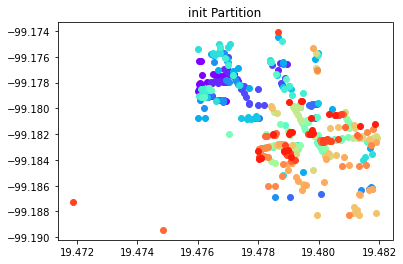

In [18]:
Gs = average_hamilton_partition(jobs, number_of_resources)

In [19]:
offset = 0
for Gi in Gs:
    one_TSP(Gi, offset)
    offset += Gi.length

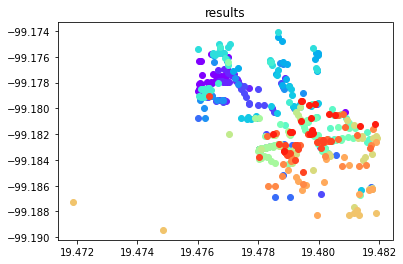

In [20]:
plot_partition(Gs, 'results')

In [21]:
for idx, G in enumerate(Gs):
    print()
    print(f'--------------- {idx} ---------------')
    print(f'Size = {G.size}')


--------------- 0 ---------------
Size = 3855.4436341734176

--------------- 1 ---------------
Size = 4093.877395465235

--------------- 2 ---------------
Size = 4662.228707359783

--------------- 3 ---------------
Size = 4217.957635521002

--------------- 4 ---------------
Size = 3290.4341994211923

--------------- 5 ---------------
Size = 3493.426959485638

--------------- 6 ---------------
Size = 4271.18334121109

--------------- 7 ---------------
Size = 3326.75305567982

--------------- 8 ---------------
Size = 3175.7586445795264

--------------- 9 ---------------
Size = 3882.6106096947287

--------------- 10 ---------------
Size = 3901.914007897726

--------------- 11 ---------------
Size = 3324.1567940392524

--------------- 12 ---------------
Size = 3171.6928918790377

--------------- 13 ---------------
Size = 2988.7881342413066

--------------- 14 ---------------
Size = 3625.6619211834363

--------------- 15 ---------------
Size = 3301.0446220223625

--------------- 16 -------

17


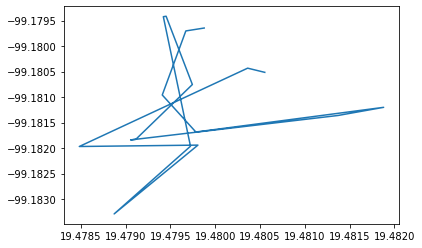

In [22]:
i = 20
lat, lon = Gs[i].get_jobs_location()
plt.plot(lat, lon)
print(len(Gs[i].V))

In [23]:
# get IDC_index column number 
idc_index_col_number = [i for i in range(len(df.columns)) if df.columns[i] == 'IDC_Index__c'][0]

In [24]:
for G in Gs:
    for v in G.V:
        df.iloc[v.id, idc_index_col_number] = v.index

In [25]:
if dict_of_duplicates:
    print('-flag-')
    for key, values in dict_of_duplicates.items():
        if values:
            for value_idx in values:
                df.iloc[value_idx, idc_index_col_number] = df.iloc[key, idc_index_col_number] 

-flag-


In [26]:
df

,_,Id,AppointmentNumber,DueDate,Latitude,DurationInMinutes,Longitude,IDC_Index__c
0,[ServiceAppointment],08p4L000000lJmbQAE,SA-3699,2021-10-08T22:59:00.000+0000,19.476372,8,-99.179075,435
1,[ServiceAppointment],08p4L000000lJmcQAE,SA-3700,2021-10-08T22:59:00.000+0000,19.478785,8,-99.178168,133
2,[ServiceAppointment],08p4L000000lJlbQAE,SA-3637,2021-10-08T22:59:00.000+0000,19.476777,8,-99.177451,0
3,[ServiceAppointment],08p4L000000lJlcQAE,SA-3638,2021-10-08T22:59:00.000+0000,19.476031,8,-99.178510,22
4,[ServiceAppointment],08p4L000000lJldQAE,SA-3639,2021-10-08T22:59:00.000+0000,19.476653,8,-99.177475,26
...,...,...,...,...,...,...,...,...
1495,[ServiceAppointment],08p4L000000lJUcQAM,SA-2584,2021-10-08T22:59:00.000+0000,19.476960,8,-99.176940,5
1496,[ServiceAppointment],08p4L000000lJUdQAM,SA-2585,2021-10-08T22:59:00.000+0000,19.476852,8,-99.179477,63
1497,[ServiceAppointment],08p4L000000lJUeQAM,SA-2586,2021-10-08T22:59:00.000+0000,19.477306,8,-99.177747,30
1498,[ServiceAppointment],08p4L000000lJUkQAM,SA-2592,2021-10-08T22:59:00.000+0000,19.477306,8,-99.177747,30


In [27]:
df.to_excel(f'results-M-TSP_{name_of_file}_alpha_NoDuplicates.xlsx', sheet_name='results')